In [1]:
import librosa
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display

from numpy import asarray, save, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv2D, Flatten, Input, MaxPooling2D, Dropout
from keras.optimizers import Adam

In [2]:
DATASET = './DataSets/Emotions'
SAMPLE_RATE = 22050
SIGNAL_LENGTH = int(SAMPLE_RATE * 1.5) # 1.5 seconds
MFCC_NUM = 65

In [3]:
labels = {
    'Angry': 0,
    'Happy': 1,
    'Sad': 2,
    'Fearful': 3,
    'Disgusted': 4,
    'Neutral': 5,
    'Suprised': 6
}

In [4]:
def remove_silence(signal, threshold=0.005):
    """
    Remove silence at the beginning and at the end of the signal
    """
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    for j in range(len(signal)-1, 0, -1):
        if np.abs(signal[j]) > threshold:
            break
    return signal[i:j]

In [5]:
def signal_resize(signal, length=SIGNAL_LENGTH):
    """
    Cut the signal to the given length, or pad it with zeros if it is shorter
    """
    length = length
    if len(signal) > length:
        return signal[:length]
    else:
        return np.pad(signal, (0, max(0, length - len(signal))), "constant")

## Preprocesamiento

In [6]:
data = []
i = 0
start_time = time.time()
for subdir, dirs, files in os.walk(DATASET):
  print('Path: ', subdir)
  print('Class: ', i)
  for file in files:
    X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
    X = remove_silence(X)
    if len(X) == 0:
      continue

    X = signal_resize(X)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=MFCC_NUM).T
    data.append((mfcc, i))

  if files:
    i = i + 1
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

Path:  ./DataSets/Emotions
Class:  0
Path:  ./DataSets/Emotions\Angry
Class:  0
--- Data loaded. Loading time: 419.40514850616455 seconds ---
Path:  ./DataSets/Emotions\Disgusted
Class:  1
--- Data loaded. Loading time: 674.8572301864624 seconds ---
Path:  ./DataSets/Emotions\Fearful
Class:  2
--- Data loaded. Loading time: 1047.4812257289886 seconds ---
Path:  ./DataSets/Emotions\Happy
Class:  3
--- Data loaded. Loading time: 1366.763932466507 seconds ---
Path:  ./DataSets/Emotions\Neutral
Class:  4
--- Data loaded. Loading time: 1462.6104123592377 seconds ---
Path:  ./DataSets/Emotions\Sad
Class:  5
--- Data loaded. Loading time: 1607.6156876087189 seconds ---
Path:  ./DataSets/Emotions\Suprised
Class:  6
--- Data loaded. Loading time: 1659.8806176185608 seconds ---


In [7]:
save('./DataSets/convolutional.npy', asarray(data), allow_pickle=True)
data = load('./DataSets/convolutional.npy', allow_pickle=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9024\1778527870.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  save('./DataSets/convolutional.npy', asarray(data), allow_pickle=True)


# Clasificador

In [10]:
dim_1 = MFCC_NUM
dim_2 = MFCC_NUM
channel = 1
epochs = 30
batch_size = 64
verbose = 1
num_classes = len(labels.keys())

In [11]:
X, y = zip(*data)
X = np.asarray(X)
y = np.asarray(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=True, shuffle=True)
X_test,  X_val,  y_test,  y_val  = train_test_split(X_test, y_test, test_size=0.5, random_state=True, shuffle=True)

In [13]:
model = Sequential()

model.add(Input(shape=(dim_1, dim_2, channel)))
model.add(BatchNormalization())

# model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', input_shape=(dim_1, dim_2, channel)))
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(94, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 65, 65, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 65, 65, 256)       2560      
                                                                 
 dropout (Dropout)           (None, 65, 65, 256)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 65, 65, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                        

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001, beta_1=0.5), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    X_train, 
    y_train, 
    epochs = epochs, 
    batch_size = batch_size, 
    validation_data = (X_val, y_val)
)

Epoch 1/30
120/120 [==============================] - 397s 3s/step - loss: 1.8099 - accuracy: 0.2815 - val_loss: 2.0700 - val_accuracy: 0.1605
Epoch 2/30
120/120 [==============================] - 418s 3s/step - loss: 1.5227 - accuracy: 0.3885 - val_loss: 2.1715 - val_accuracy: 0.1605
Epoch 3/30
120/120 [==============================] - 404s 3s/step - loss: 1.3909 - accuracy: 0.4388 - val_loss: 1.9666 - val_accuracy: 0.1668
Epoch 4/30
120/120 [==============================] - 439s 4s/step - loss: 1.3250 - accuracy: 0.4691 - val_loss: 1.6681 - val_accuracy: 0.3648
Epoch 5/30
120/120 [==============================] - 426s 4s/step - loss: 1.2825 - accuracy: 0.4928 - val_loss: 1.4205 - val_accuracy: 0.4742
Epoch 6/30
120/120 [==============================] - 412s 3s/step - loss: 1.2454 - accuracy: 0.5086 - val_loss: 1.3092 - val_accuracy: 0.4895
Epoch 7/30
120/120 [==============================] - 446s 4s/step - loss: 1.2033 - accuracy: 0.5280 - val_loss: 1.2029 - val_accuracy: 0.5434

KeyboardInterrupt: 

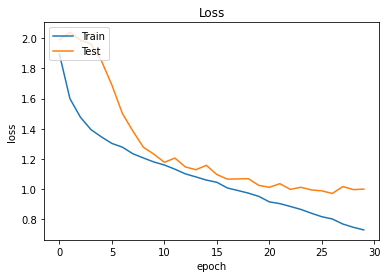

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

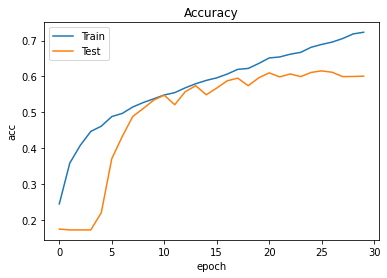

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [68]:
predictions = np.argmax(model.predict(X_test),axis=1)
y_test = y_test.astype(int)
report = classification_report(y_test, predictions)
print(report)

80/80 [==============================] - 21s 262ms/step
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       448
           1       0.41      0.69      0.51       371
           2       0.42      0.67      0.51       398
           3       0.77      0.49      0.60       433
           4       0.90      0.47      0.61       353
           5       0.84      0.42      0.56       439
           6       0.78      0.94      0.85       117

    accuracy                           0.61      2559
   macro avg       0.70      0.64      0.63      2559
weighted avg       0.69      0.61      0.61      2559



## Matriz de confusion

<AxesSubplot:>

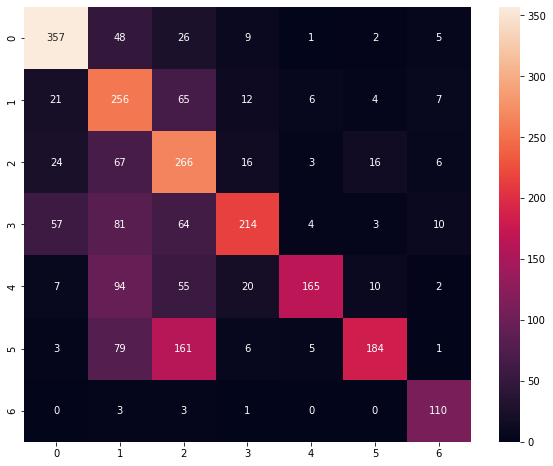

In [69]:
matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d")